## EXPERIMENT 1: AdaFace

In [1]:
## Load libraries

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *

from IPython import embed

from DET_utils.DET_plots import *
from DET_utils.DET import *

from IPython import embed


### MagFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

### Load data

In [5]:
feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/similarity_scores_children_full_baseline1.pt'


image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors(feature_list_children)
# ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_canonical_df_BIBLE.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

In [6]:
her = 584
print(image_names_c[her], ids_c[her], num_ids_c[her])
print(image_names_a[her], ids_a[her], num_ids_a[her])

African_265_0 African_265 169
African_265_0 African_265 169


### GET METRICS 10 TIMES

In [7]:
def balance_child_data_can(y_df, print_stats=False, random_state=42):
    """
    Input: raw df for ylfw and rfw
    Returns: csvs with equally balanced children and adults
    Original child_balanced has random state 42
    """

    # Randomly sample 1000 identities from the entire dataset
    ylfw_witha_balanced = y_df.sample(n=2000, random_state=random_state)

    if print_stats:
        # Print the distribution of age groups and other relevant statistics
        print("Balanced data?:", ylfw_witha_balanced.children_agegroup.value_counts())

    return ylfw_witha_balanced


In [8]:


random_states = [1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_magface_ex1_1 = {}
FNIR_c_list=[]
FNIR_a_list=[]
FPIR_c_list=[]
FPIR_a_list=[]
FPD_list=[]
FND_list=[]
GARBE_list=[]
threshold_list = []
# percentile = 94

for random_state_i in random_states:

    ### Load children and adults balanced data ###
    children_balanced_df_i = balance_child_data_can(children_all, print_stats=False, random_state=random_state_i)
    adults_balanced_df_i = balance_child_data(adults_all, print_stats=False, random_state=random_state_i)


    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)


    ### All reference image names, enrolled and non-enrolled image names - adults ###
    a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
    non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
    all_reference_image_names_a = list(adults_balanced_df_i.image_name)



    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a]



    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]


    sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

    # Extract corresponding rows from the numerical ids
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_a_reference = num_ids_a[indices_a_all_reference]


    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a]


    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

    # Extract corresponding rows from the numerical ids
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]


    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

    # Extract corresponding rows from the numerical ids
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_a_enrolled = num_ids_a[indices_a_enrolled]


    ### DET THINGS ###

    # thold = (np.percentile(sim_mat_c,90)+np.percentile(sim_mat_a,90))/2
    # thold = ((np.percentile(sim_mat_c_non_enrolled_0,90) + (np.percentile(sim_mat_a_non_enrolled_0,90)))/2 + (np.percentile(sim_mat_c_enrolled_0,90) + (np.percentile(sim_mat_a_enrolled_0,90)))/2 )/2
    # thold = np.percentile(sim_mat_a, 99)
    thold = 0.24
    # thold = (np.percentile(sim_mat_c,percentile)+np.percentile(sim_mat_a,percentile))/2

    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
    FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)




    # OBS maybe compute Garbe outside funtion to choose a good alpha?
    alpha_garbe = 0.25
    FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)


    FNIR_c_list.append(FNIR_c)
    FNIR_a_list.append(FNIR_a)
    FPIR_c_list.append(FPIR_c)
    FPIR_a_list.append(FPIR_a)
    FPD_list.append(FPD_i)
    FND_list.append(FND_i)
    GARBE_list.append(GARBE_i)
    threshold_list.append(thold)

    sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_a_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled_0)
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_a_non_enrolled_0)


    print("done")

data = {
    'Iteration': random_states,
    'FNIR_c': FNIR_c_list,
    'FNIR_a': FNIR_a_list,
    'FPIR_c': FPIR_c_list,
    'FPIR_a': FPIR_a_list,
    'FPD': FPD_list,
    'FND': FND_list,
    'GARBE': GARBE_list,
    'Threshold': threshold_list
}


FPD result:  0.0
FND result:  0.4163865449258864
GARBE result, GARBE close to 1 means more unfair:  0.3122899086944148
done
FPD result:  0.0
FND result:  0.39704591157560826
GARBE result, GARBE close to 1 means more unfair:  0.2977844336817062
done
FPD result:  0.0
FND result:  0.3469832054737715
GARBE result, GARBE close to 1 means more unfair:  0.2602374041053286
done
FPD result:  0.0
FND result:  0.40864564263756
GARBE result, GARBE close to 1 means more unfair:  0.30648423197817
done
FPD result:  0.0
FND result:  0.3742174653088307
GARBE result, GARBE close to 1 means more unfair:  0.280663098981623
done
FPD result:  0.0
FND result:  0.33780065678530224
GARBE result, GARBE close to 1 means more unfair:  0.2533504925889767
done
FPD result:  0.0
FND result:  0.37766579430926
GARBE result, GARBE close to 1 means more unfair:  0.283249345731945
done
FPD result:  0.0
FND result:  0.3493556612225209
GARBE result, GARBE close to 1 means more unfair:  0.26201674591689067
done
FPD result:  

# Stats

In [ ]:
df_all_results = pd.DataFrame(data)

In [ ]:
df_all_results

In [ ]:
df_all_results.describe().applymap(lambda x: f"{x:.3f}")

# Threshold

In [ ]:


# df_all_results
df_all_threshold_84 = pd.DataFrame(data)
data_threshold_plot = pd.concat([data_threshold_plot, df_all_threshold_84 ])
data_threshold_plot
data_threshold_plot.sort_values(by = 'Threshold')
# group by threshold
plot_df = data_threshold_plot.groupby('Threshold').mean()
plot_df
plot_df.to_csv('magface_1_2_threshold_FNIR_plot.csv')
# Plotting FNIR and FPIR vs. Threshold
plt.figure(figsize=(14, 7))

# Plot FNIR
plt.subplot(1, 2, 1)
plt.plot(plot_df.index, plot_df['FNIR_c'], 'r-', label='Canonical - children')
plt.plot(plot_df.index, plot_df['FNIR_a'], 'c-', label='Mixed quality - children')
# plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('FNIR')
plt.title('FNIR vs Threshold')
plt.legend()

# Plot FPIR
plt.subplot(1, 2, 2)
plt.plot(plot_df.index, plot_df['FPIR_c'], 'r-', label='Canonical - children')
plt.plot(plot_df.index, plot_df['FPIR_a'], 'c-', label='Mixed quality - children')
# plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('FPIR')
plt.title('FPIR vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()


# Saving sim to plot all of the dist


In [9]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_ada_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_ada_1_2.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))

# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_ada_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_ada_1_2.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


101316
141482
14218887
32751054


In [10]:

# Loading pre-saved stuff
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_ada_1_2.csv')).values.flatten()


# From DET utils - check import

In [11]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [12]:
mated_scores1 = sim_mat_a_enrolled_iterations_all
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,141482.000000,3.275105e+07
1,Minimum,0.030712,-3.204173e-01
2,Maximum,0.998967,9.998881e-01
3,Mean,0.572877,1.315970e-01
4,St. Dev.,0.156216,1.199958e-01
5,Skewness,-0.241955,3.998172e-01
6,Ex. Kurtosis,-0.089465,1.713026e-01


In [13]:
mated_scores2 = sim_mat_c_enrolled_iterations_all

nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,101316.000000,1.421889e+07
1,Minimum,0.030712,-3.182690e-01
2,Maximum,0.998967,9.998881e-01
3,Mean,0.598583,1.374914e-01
4,St. Dev.,0.151694,1.226022e-01
5,Skewness,-0.352376,4.172224e-01
6,Ex. Kurtosis,0.081476,3.001004e-01


In [14]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [15]:
# def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
#     def normalise_scores(distribution):
#         return np.ones_like(distribution) / len(distribution)
#     plt.figure(figsize=figure_size)
#     if normalise:
#         plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
#         plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
#         xlabel = "Probability Density"
#     else:
#         plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
#         plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
#         xlabel = "Count"
#     plt.xlabel("Comparison Score", size=label_fontsize)
#     plt.ylabel(xlabel, size=label_fontsize)
#     plt.grid(True)
#     plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

#     if savename is not None:
#         plt.savefig(savename, bbox_inches="tight")
#         plt.cla()
#         plt.clf()
#         plt.close()
#     else:
#         plt.show()


def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)

    mated_mean = np.mean(mated_scores)

    plt.figure(figsize=figure_size)

    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
        ylabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
        ylabel = "Count"

    plt.axvline(mated_mean, color='darkred', linestyle='--', linewidth=2, label=f'Mated Mean: {mated_mean:.2f}')

    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(ylabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

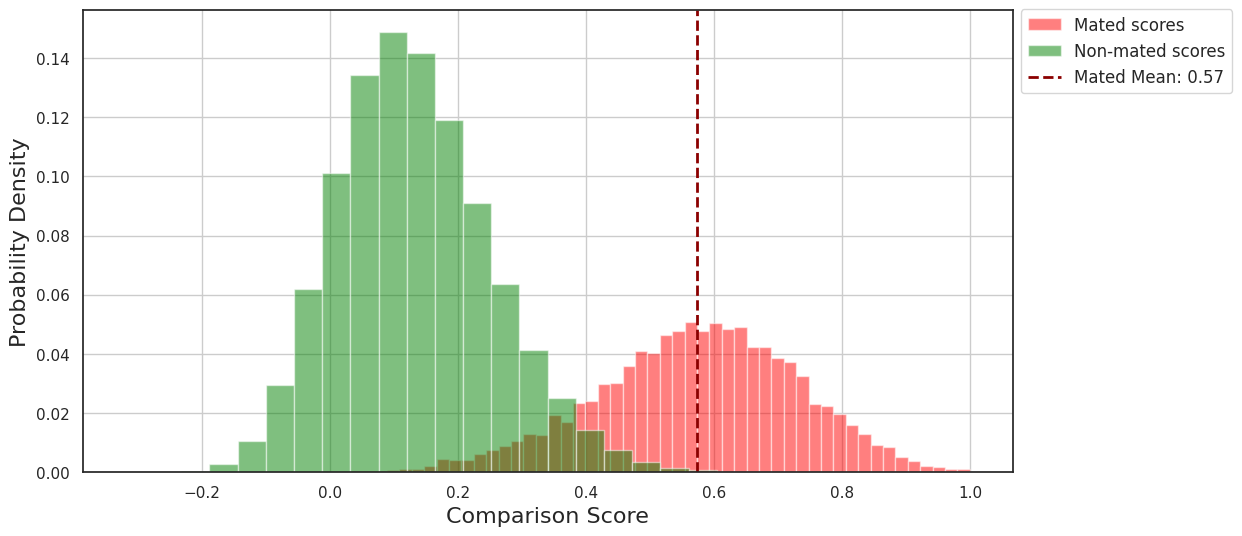

In [16]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True)


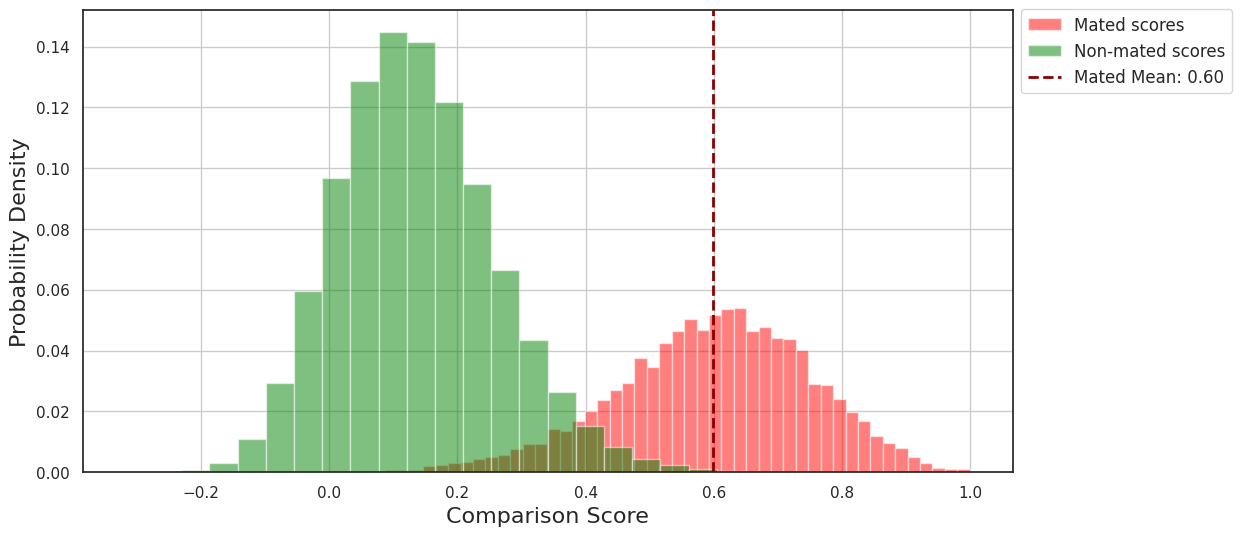

In [17]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)


# DET CURVES

In [18]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)

In [20]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' mixed =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' canonical =", round(d_prime_system2, round_digits))


d' mixed = 3.16811
d' canonical = 3.34325


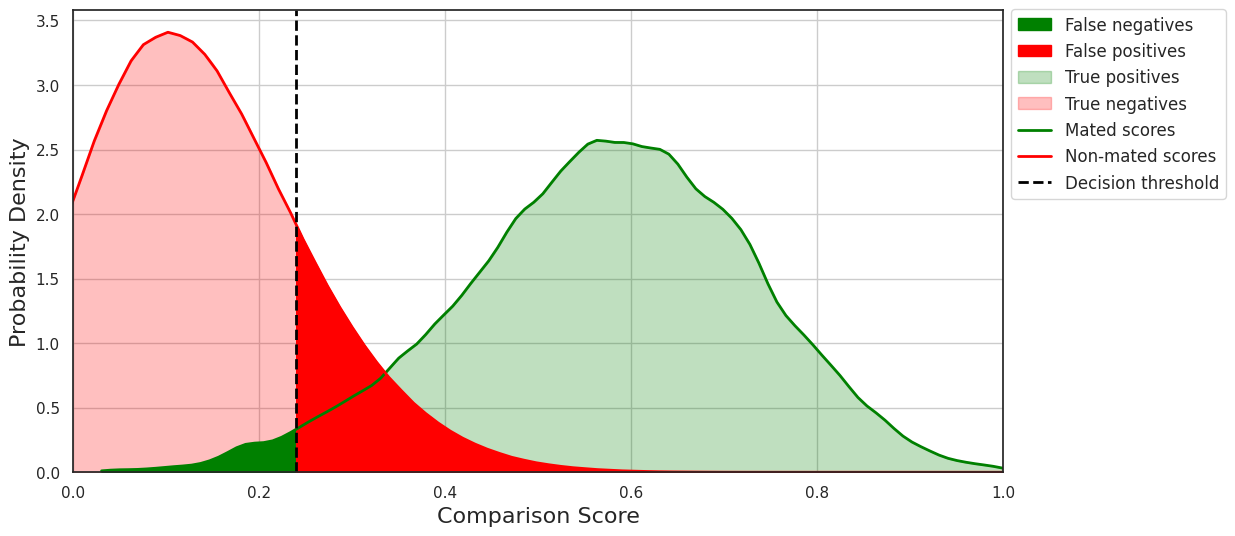

In [21]:
threshold1 = 0.24
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

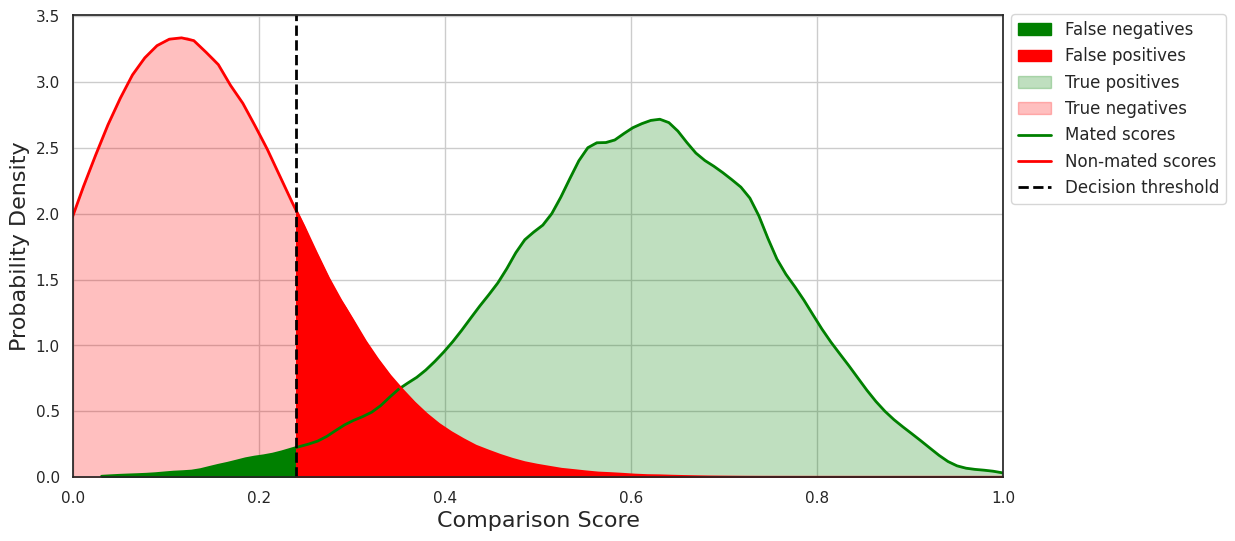

In [22]:
threshold2 = 0.24
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

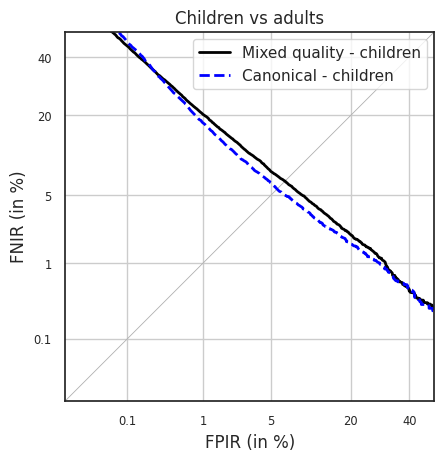

In [23]:
system_name1 = 'Mixed quality - children'
system_name2 = 'Canonical - children'

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()